# Заняття 7

## Мета:
Створити просту генеративно-змагальну мережу (GAN) для генерації зображень, використовуючи набір даних MNIST, який складається з рукописних цифр.

---

## Кроки для виконання завдання:

### 1. Завантаження та попередня обробка даних:
- Завантажте набір даних MNIST (він доступний як в TensorFlow, так і в PyTorch).
- Нормалізуйте значення пікселів до діапазону `[-1, 1]`, що покращить процес навчання GAN.

### 2. Створення архітектури генератора:
- Створіть генератор, який приймає випадковий шум на вході (наприклад, вектор розміром 100).
- Генератор може складатися з декількох шарів (Dense) з функціями активації ReLU і завершуватися вихідним шаром із функцією активації tanh, щоб генерувати зображення розміром 28x28.

### 3. Створення архітектури дискримінатора:
- Створіть дискримінатор, який приймає зображення розміром 28x28 як вхід.
- Дискримінатор може складатися з декількох повнозв’язних шарів (Dense) з функціями активації LeakyReLU.
- Останній шар має мати один вихід із функцією активації sigmoid для визначення, чи є зображення реальним чи згенерованим.

### 4. Налаштування втрат та оптимізаторів:
- Виберіть функцію втрат `binary cross-entropy` для обох мереж.
- Виберіть оптимізатори, такі як Adam, з відповідними коефіцієнтами навчання (зазвичай 0.0002).

### 5. Об'єднання моделей та навчання GAN:
- Навчайте дискримінатор окремо, використовуючи реальні зображення MNIST та згенеровані зображення від генератора.
- Після кожного оновлення дискримінатора, навчайте генератор з метою "обдурити" дискримінатор.
- Виконайте процес навчання в декілька епох, генеруючи зображення на кожній епосі для оцінки прогресу.

### 6. Оцінка та візуалізація результатів:
- Після кожної епохи або кількох епох візуалізуйте згенеровані зображення, щоб бачити покращення.
- Збережіть найкращі згенеровані зображення та модель генератора для подальшого використання.

### 7. Підведення підсумків:
- Опишіть отримані результати, зокрема, як змінювались згенеровані зображення протягом навчання.
- Проаналізуйте, чи вдалося досягти реалістичних зображень цифр, та які аспекти можна було б покращити в моделі.

---

## Мінімальні вимоги:
- Створити та навчити простий GAN на наборі даних MNIST.
- Досягти генерації зображень, які схожі на рукописні цифри.

---

## Формат виконання:
- `.ipynb` блокнот з кодом та візуалізацією, або ж код в `.py` з прикріпленими зображеннями результатів на GitHub.


# Generative Adversarial Network (GAN) на датасеті MNIST

У цьому ноутбуці ми:
- Завантажимо датасет MNIST
- Підготуємо дані (нормалізація)
- Створимо простий генератор та дискримінатор (Fully Connected Layers)
- Навчимо GAN за допомогою власного циклу навчання
- Візуалізуємо проміжні результати генерації зображень



## Імпорт бібліотек

In [1]:

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os

# Перевірка версії TensorFlow
print("TensorFlow version:", tf.__version__)

# Створимо директорію для збереження зображень, якщо її немає
os.makedirs("generated_images", exist_ok=True)

TensorFlow version: 2.18.0


## Завантаження та підготовка даних MNIST

In [2]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Нормалізація даних до діапазону [-1, 1]
# Спершу перетворимо тип і нормалізуємо до [0,1], потім масштабування до [-1,1]
x_train = x_train.astype("float32") / 255.0
x_train = x_train * 2.0 - 1.0  # з [0,1] у [-1,1]
x_train = np.expand_dims(x_train, axis=-1)  # розширення розмірності (N,28,28,1)

print("Shape of training data:", x_train.shape)

Shape of training data: (60000, 28, 28, 1)


## Гіперпараметри

In [3]:

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100  # розмір вхідного шуму до генератора
EPOCHS = 30  # можна змінити
num_examples_to_generate = 16

# Підготуємо датасет
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

## Побудова генератора

In [4]:

def make_generator_model():
    model = models.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.ReLU())

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.ReLU())

    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.ReLU())

    # Вихідний шар: 28*28*1 = 784 нейрон
    model.add(layers.Dense(28 * 28 * 1, use_bias=False, activation="tanh"))
    model.add(layers.Reshape((28, 28, 1)))

    return model


generator = make_generator_model()
generator.summary()

/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       802,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,483,776 (5.66 MB)

 Trainable params: 1,483,776 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

## Побудова дискримінатора

In [5]:



def make_discriminator_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Вихід: 1 нейрон зі sigmoid
    model.add(layers.Dense(1, activation="sigmoid"))
    return model


discriminator = make_discriminator_model()
discriminator.summary()

/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

## Функції втрат та оптимізатори

In [6]:


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

## Тренувальний цикл

In [7]:

# Вектор фіксованого шуму, щоб відстежувати прогрес генератора
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss

## Функція для візуалізації згенерованих зображень

In [11]:

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Зворотнє перетворення до діапазону [0,1]
        img = (predictions[i, :, :, 0] + 1.0) / 2.0
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.savefig(f"generated_images/image_at_epoch_{epoch:03d}.png")
    if epoch % 5 == 0:
        plt.show()

## Основний цикл навчання

2024-12-14 20:27:06.144663: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Gen loss: 2.8048, Disc loss: 0.4270


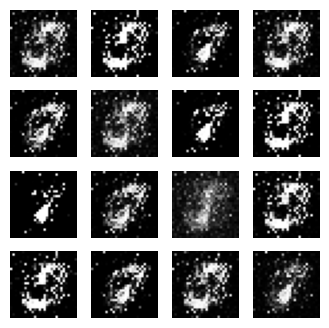

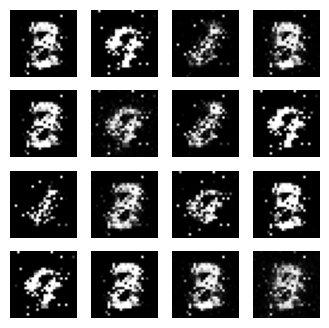

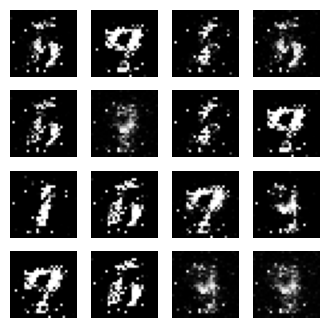

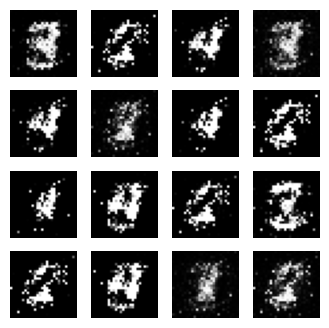

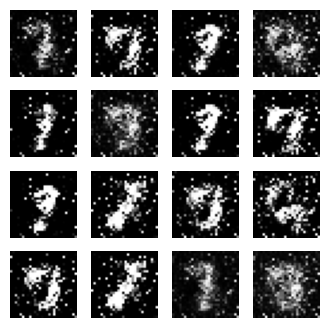

Epoch 10, Gen loss: 1.7035, Disc loss: 0.7680


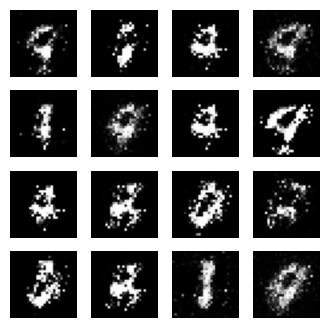

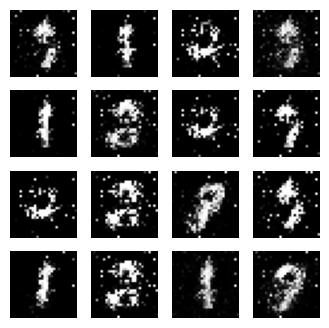

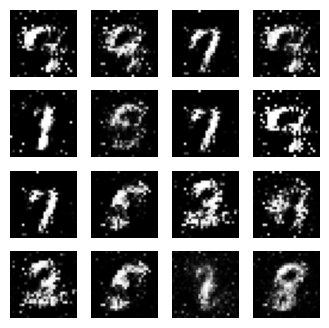

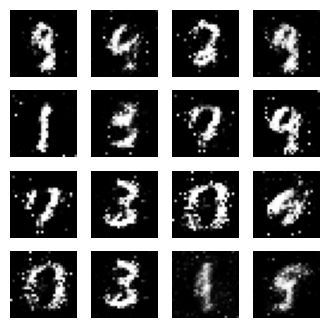

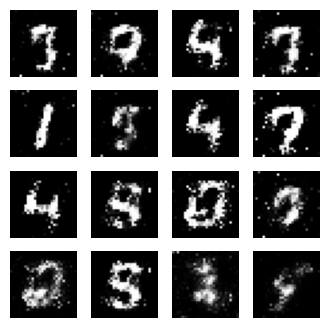

Epoch 15, Gen loss: 1.2854, Disc loss: 0.9705


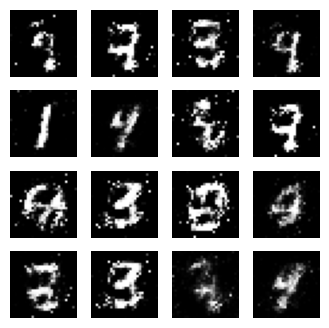

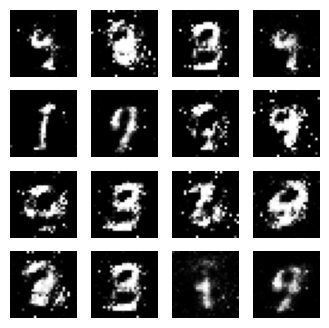

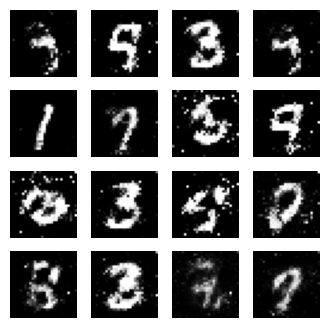

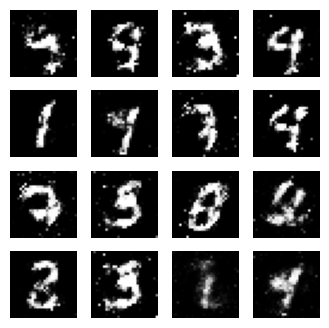

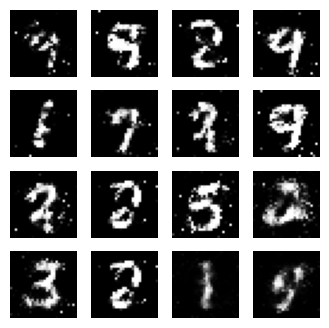

2024-12-14 20:28:24.993147: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20, Gen loss: 1.1595, Disc loss: 1.0449


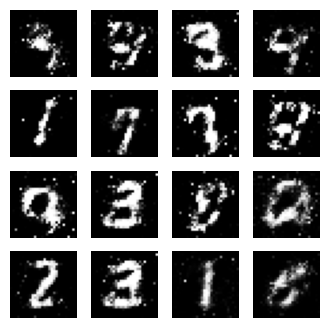

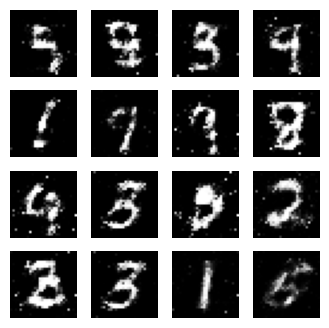

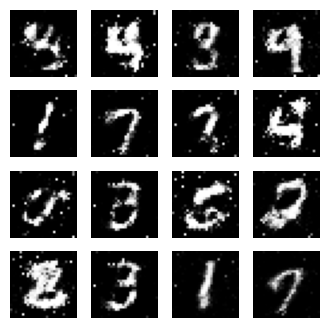

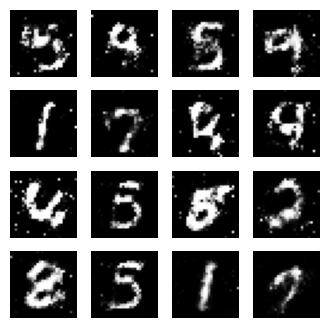

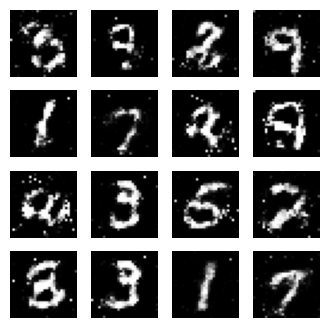

Epoch 25, Gen loss: 1.1420, Disc loss: 1.0655


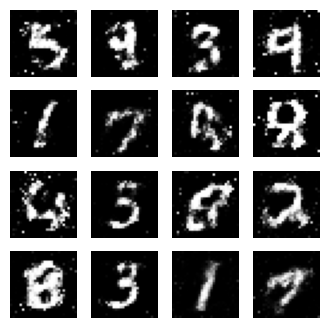

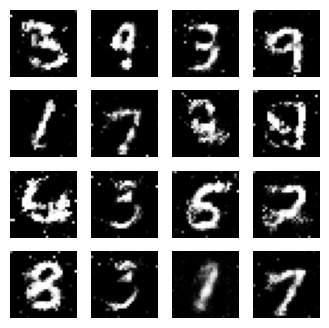

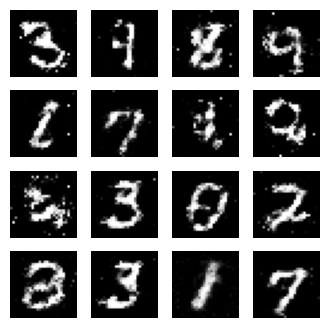

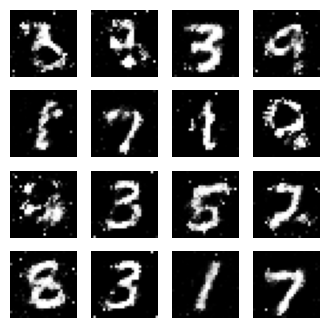

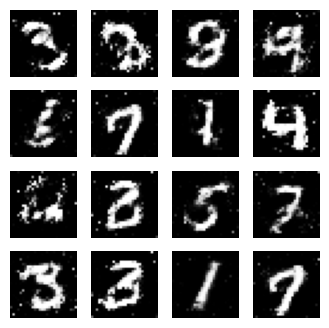

Epoch 30, Gen loss: 1.1121, Disc loss: 1.0835


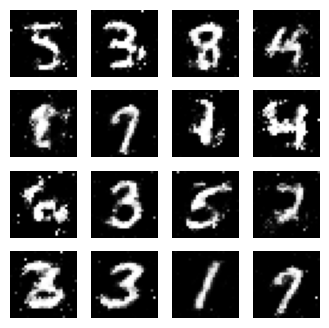

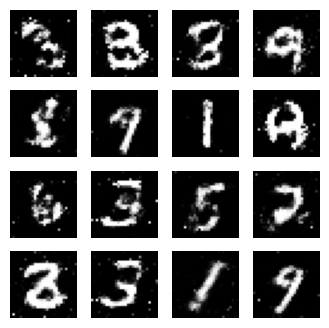

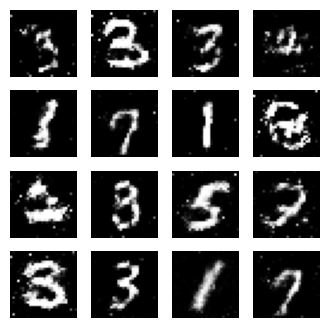

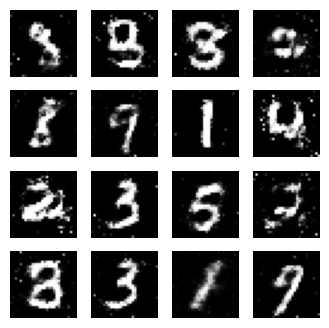

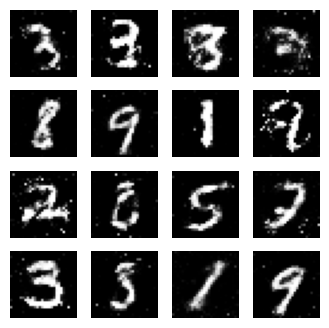

In [12]:


for epoch in range(1, EPOCHS + 1):
    gen_loss_list = []
    disc_loss_list = []
    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
        gen_loss_list.append(g_loss.numpy())
        disc_loss_list.append(d_loss.numpy())

    # Після завершення епохи - виведемо середні втрати
    if epoch % 5 == 0:
        print(
            f"Epoch {epoch}, Gen loss: {np.mean(gen_loss_list):.4f}, Disc loss: {np.mean(disc_loss_list):.4f}"
        )

    # Згенеруємо та збережемо зображення
    generate_and_save_images(generator, epoch, seed)

## Збереження моделі генератора після навчання

In [ ]:

generator.save("generator_model.keras")
print("Модель генератора збережена.")

Модель генератора збережена.


## Тестування моделі генератора

### Генерація нового набору зображень з випадковим шумом

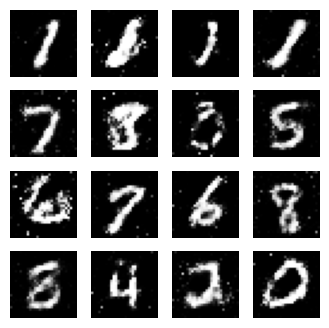

In [18]:
# Генеруємо новий набір шуму:
random_noise = tf.random.normal([16, LATENT_DIM])  # 16 прикладів
generated_images = generator(random_noise, training=False)

# Візуалізація
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    img = (generated_images[i, :, :, 0] + 1) / 2.0  # привести до [0,1]
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

### Завантаження збереженої моделі та генерація зображень

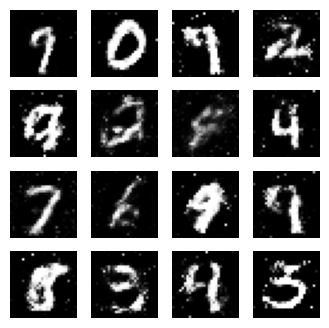

In [20]:
# Завантажуємо модель генератора
restored_generator = tf.keras.models.load_model("generator_model.keras", compile=False)

# Генеруємо нові зображення за допомогою відновленої моделі
random_noise = tf.random.normal([16, LATENT_DIM])
restored_images = restored_generator(random_noise, training=False)

fig = plt.figure(figsize=(4, 4))
for i in range(restored_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    img = (restored_images[i, :, :, 0] + 1) / 2.0
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

### Інтерполяція між двома векторами шуму

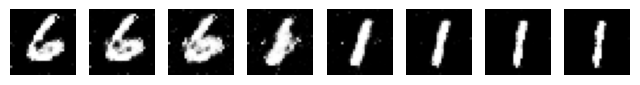

In [19]:
# Створимо два випадкові вектори шуму
z1 = tf.random.normal([1, LATENT_DIM])
z2 = tf.random.normal([1, LATENT_DIM])

num_steps = 8  # кількість кроків інтерполяції
fig = plt.figure(figsize=(num_steps, 1))

for i, alpha in enumerate(np.linspace(0, 1, num_steps)):
    # Лінійна інтерполяція між z1 і z2: z = z1 * (1 - alpha) + z2 * alpha
    z = (1 - alpha) * z1 + alpha * z2
    interpolated_image = generator(z, training=False)

    plt.subplot(1, num_steps, i + 1)
    img = (interpolated_image[0, :, :, 0] + 1) / 2.0
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()